In [38]:
import sys
import os
from typing import List, Dict, Tuple, Any
import argparse
import yaml

model_path = "../../../../data1/donghoon/FederatedScopeData/exp/ml-1m/hidden_size_64_CE_lr1-e4_epoch_20_shadow_round_30K.pt"
config_path = "exp/shadow_sasrec_on_sr_data_lr0.001_lstep20/sub_exp_20240813160404/config.yaml"



#model_path = "../../../../data1/donghoon/FederatedScopeData/exp/ml-1m/0813_shuffle_aug_hidden_size_64_CE_lr1-e4_epoch_1_shadow_round_30K.pt"
#config_path = "exp/shadow_sasrec_on_sr_data_lr0.001_lstep1/ML-1M_augmentation/shuffle/config.yaml"

## 
#model_path = "../../../../data1/donghoon/FederatedScopeData/exp/ml-1m/0813_cut-aug_left_hidden_size_64_CE_lr1-e4_epoch_1_shadow_round_30K.pt"
#config_path = "exp/shadow_sasrec_on_sr_data_lr0.001_lstep1/ML-1M_augmentation/cut_from_left/config.yaml"

with open(config_path, 'r') as str_obj:
    cfg_as_dict = yaml.safe_load(str_obj)




In [39]:
## get data loader
import pandas as pd
from federatedscope.contrib.data.sr_data import SequentialRecommendationDataset, SequentialRecommendationDatasetWithAugmentation
from torch.utils.data import Dataset, DataLoader

partitioned_df_path = cfg_as_dict["data"]["partitioned_df_path"]

save_partitioned_df_path = cfg_as_dict["data"]["save_partitioned_df_path"]
train_df = pd.read_csv(os.path.join(partitioned_df_path, 'train.csv'))
valid_df = pd.read_csv(os.path.join(partitioned_df_path, 'valid.csv'))
test_df = pd.read_csv(os.path.join(partitioned_df_path, 'test.csv'))

if cfg_as_dict["data"]["use_augmentation"] :
    augmentation_column = cfg_as_dict["data"]["augmentation_column"]
    max_augmentation_idx = cfg_as_dict["data"]["max_augmentation_idx"]
    train_with_augmentation_df = train_df[train_df[augmentation_column] <= max_augmentation_idx]
    train_with_augmentation_df = train_with_augmentation_df.reset_index(drop=True)

    trainset = SequentialRecommendationDatasetWithAugmentation(
        df_with_augmentation = train_with_augmentation_df,
        user_column = cfg_as_dict["data"]["user_column"],
        item_column = cfg_as_dict["data"]["item_column"],
        interaction_column = cfg_as_dict["data"]["interaction_column"],
        timestamp_column = cfg_as_dict["data"]["timestamp_column"],
        augmentation_column = cfg_as_dict["data"]["augmentation_column"],
        min_sequence_length = cfg_as_dict["data"]["min_sequence_length"],
        max_sequence_length = cfg_as_dict["data"]["max_sequence_length"],
        user_num = cfg_as_dict["data"]["user_num"],
        item_num = cfg_as_dict["data"]["item_num"],
        padding_value = cfg_as_dict["data"]["padding_value"]
    )
else :
    trainset = SequentialRecommendationDataset(
        df = train_df,
        user_column = cfg_as_dict["data"]["user_column"],
        item_column = cfg_as_dict["data"]["item_column"],
        interaction_column = cfg_as_dict["data"]["interaction_column"],
        timestamp_column = cfg_as_dict["data"]["timestamp_column"],
        min_sequence_length = cfg_as_dict["data"]["min_sequence_length"],
        max_sequence_length = cfg_as_dict["data"]["max_sequence_length"],
        user_num = cfg_as_dict["data"]["user_num"],
        item_num = cfg_as_dict["data"]["item_num"],
        padding_value = cfg_as_dict["data"]["padding_value"]
    )

validset = SequentialRecommendationDataset(
    df = valid_df,
    user_column = cfg_as_dict["data"]["user_column"],
    item_column = cfg_as_dict["data"]["item_column"],
    interaction_column = cfg_as_dict["data"]["interaction_column"],
    timestamp_column = cfg_as_dict["data"]["timestamp_column"],
    min_sequence_length = cfg_as_dict["data"]["min_sequence_length"],
    max_sequence_length = cfg_as_dict["data"]["max_sequence_length"],
    user_num = cfg_as_dict["data"]["user_num"],
    item_num = cfg_as_dict["data"]["item_num"],
    padding_value = cfg_as_dict["data"]["padding_value"]
)
    
testset = SequentialRecommendationDataset(
    df = test_df,
    user_column = cfg_as_dict["data"]["user_column"],
    item_column = cfg_as_dict["data"]["item_column"],
    interaction_column = cfg_as_dict["data"]["interaction_column"],
    timestamp_column = cfg_as_dict["data"]["timestamp_column"],
    min_sequence_length = cfg_as_dict["data"]["min_sequence_length"],
    max_sequence_length = cfg_as_dict["data"]["max_sequence_length"],
    user_num = cfg_as_dict["data"]["user_num"],
    item_num = cfg_as_dict["data"]["item_num"],
    padding_value = cfg_as_dict["data"]["padding_value"]
)

## split by user
from federatedscope.contrib.splitter.sr_splitter import SRSpliiter

sr_splitter = SRSpliiter(6040)
train_list = sr_splitter(trainset)
valid_list = sr_splitter(validset)
test_list = sr_splitter(testset)

print(valid_list[1])

In [40]:
print(len(train_list), len(valid_list), len(test_list))
assert len(train_list) == len(valid_list) == len(test_list)
user_num = len(train_list)

6040 6040 6040


In [41]:

import torch
from federatedscope.contrib.model.sasrec import SASRec
## load model
model_dict = torch.load(model_path)
saved_round = model_dict['cur_round']
model_param = model_dict['model']

sasrec_model = SASRec(
    user_column = cfg_as_dict["data"]["user_column"],
    item_column = cfg_as_dict["data"]["item_column"],
    max_sequence_length = cfg_as_dict["data"]["max_sequence_length"],
    item_num = cfg_as_dict["model"]["item_num"],
    n_layers = cfg_as_dict["model"]["n_layers"],
    n_heads = cfg_as_dict["model"]["n_heads"],
    hidden_size = cfg_as_dict["model"]["hidden_size"],
    inner_size = cfg_as_dict["model"]["inner_size"],
    hidden_dropout_prob = cfg_as_dict["model"]["hidden_dropout_prob"],
    attn_dropout_prob = cfg_as_dict["model"]["attn_dropout_prob"],
    hidden_act = cfg_as_dict["model"]["hidden_act"],
    layer_norm_eps = cfg_as_dict["model"]["layer_norm_eps"],
    initializer_range = cfg_as_dict["model"]["initializer_range"],
    use_position = cfg_as_dict["model"]["use_position"],
    device = cfg_as_dict["model"]["device"]
)

sasrec_model.load_state_dict(model_param) 


<All keys matched successfully>

In [42]:
from federatedscope.contrib.metrics.recall_ndcg import recall_k_from_top_N, ndcg_k_from_top_N

## eval per user, track recall@20 and ndcg@20 by user
device = cfg_as_dict["model"]["device"]
sasrec_model.to(device)
sasrec_model.eval()

train_batch_size = 1
if cfg_as_dict["data"]["use_augmentation"] :
    train_batch_size = 1 + max_augmentation_idx

user_via_record = {
    "user_id": [],
    "target_item": [],
    "top100_scores": [],
    "top100_indices": [],
    "target_score" : [],
    "recall_20": [],
    "ndcg_20": [],
    "loss" : [],
    #"train_avg_loss" : []
}

criterion = torch.nn.CrossEntropyLoss()


for user_idx in range(user_num):
    #current_train = train_list[user_idx]
    current_valid = valid_list[user_idx]
    
    #train_loader = DataLoader(current_train, batch_size = train_batch_size, shuffle = False)
    valid_loader = DataLoader(current_valid, batch_size = 1, shuffle = False)
    
    ## get the avg train loss
    """
    train_loss = []
    for train_batch in train_loader :
        with torch.no_grad():
            item_seq = train_batch["item_seq"].to(device)
            item_seq_len = train_batch['item_seq_len'].to(device)
            target_item = train_batch["target_item"].to(device)

            output = sasrec_model(item_seq, item_seq_len)
            logits = torch.matmul(output, sasrec_model.item_embedding.weight.transpose(0, 1))
            y_true = target_item
            
            loss = criterion(logits, target_item)
            train_loss.append(loss.item())
            
    user_via_record["train_avg_loss"].append(sum(train_loss) / len(train_loss))
    
    """
    
    ## get the metrics, score, and loss
    for valid_batch in valid_loader:
        with torch.no_grad():
            item_seq = valid_batch["item_seq"].to(device)
            item_seq_len = valid_batch['item_seq_len'].to(device)
            target_item = valid_batch["target_item"].to(device)

            output = sasrec_model(item_seq, item_seq_len)
            test_item_emb = sasrec_model.item_embedding.weight

            logits = torch.matmul(output, test_item_emb.transpose(0, 1))
            y_true = target_item
            
            target_score = logits[0, target_item].item()
            top100_scores, top100_indices = torch.topk(logits, 100, dim = 1)

            recall_20 = recall_k_from_top_N(y_true, top100_indices, k = 20)
            ndcg_20 = ndcg_k_from_top_N(y_true, top100_indices, k = 20)

            loss = criterion(logits, y_true)

            ## record 
            user_via_record["user_id"].append(user_idx)
            user_via_record["target_item"].append(target_item.item())
            user_via_record["target_score"].append(target_score)
            user_via_record["top100_scores"].append(top100_scores.cpu().numpy().squeeze())
            user_via_record["top100_indices"].append(top100_indices.cpu().numpy().squeeze())
            user_via_record["recall_20"].append(recall_20.item())
            user_via_record["ndcg_20"].append(ndcg_20.item())
            user_via_record["loss"].append(loss.item())

#print(user_via_record)
print(f"total {len(user_via_record['user_id'])} records are collected")

total 6040 records are collected


In [43]:
import numpy as np

## from the top100 scores calculate z-score
user_via_record["target_z_score"] = []

for idx, user_id in enumerate(user_via_record['user_id']):
    top100_scores = user_via_record['top100_scores'][idx]
    target_score = user_via_record['target_score'][idx]
    
    mean = np.mean(top100_scores)
    std = np.std(top100_scores)
    
    z_score = (target_score - mean) / std
    user_via_record["target_z_score"].append(z_score)

print(user_via_record['target_z_score'])



[1.2629297752025206, -0.022562966843541216, -0.4344599267586545, -2.3640215717344804, -7.415532540196709, -3.5258813249336014, -5.421217332448356, -5.675421458004941, -2.8193978821056294, -6.043460366425297, -8.346778653780666, -2.936025772083833, -9.360913495420265, -9.79885599961291, -2.5805272048922907, 1.9739690559323175, -5.820664668565165, -7.623579172587373, -4.304768591918483, -3.370291503117359, -2.4942423803124276, -7.51797082838005, -10.298874074673101, -7.683675461104782, -2.553180815534872, -1.6582302685012678, -2.148107915266451, -1.7257982632096363, -3.4839416864905206, -4.776157583284015, -4.538673821764218, -0.7033550121241094, -4.053445802511999, -2.793832226028334, -8.527382427539779, -5.770829763353997, -1.2434440427585929, -1.7775821984656006, -0.8188517284731438, -16.03188170551368, 1.0694961234958356, -10.523116480596151, 0.54116667089672, -5.180422369439418, -5.228829476239919, 0.05114557957054366, -2.403376620711469, -8.555108483361156, -0.4863629935668914, -12

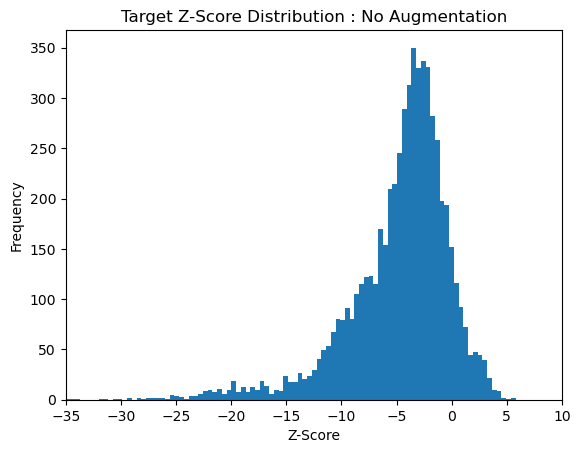

Mean : -4.795849705902193
Std : 4.799556069107689
lambda : 0.15277704845143886


In [52]:
## to evaluate Generalization and Personalization we look at target z-score distribution

import matplotlib.pyplot as plt

plt.hist(user_via_record['target_z_score'], bins = 100)
plt.title("Target Z-Score Distribution : No Augmentation")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.xlim(-35, 10)
plt.show()

print(f"Mean : {np.mean(user_via_record['target_z_score'])}")
print(f"Std : {np.std(user_via_record['target_z_score'])}")

## if we look at as a poisson distribution and calculate the lambda
## get the left right inverse and normalized mean
print(f"lambda : {np.mean(user_via_record['target_z_score'])  / (max(user_via_record['target_z_score']) - min(user_via_record['target_z_score']) * -1)}")



In [45]:
## we also evaluate the item frequency for the top 100 items
## 1. first count all the top 100 items
top100_recommended_item_counts = {}

for idx, user_id in enumerate(user_via_record['user_id']):
    top100_indices = user_via_record['top100_indices'][idx]
    for item in top100_indices:
        if item in top100_recommended_item_counts:
            top100_recommended_item_counts[item] += 1
        else:
            top100_recommended_item_counts[item] = 1

print("variety of top 100 items : ", len(top100_recommended_item_counts))
print("mean frequency of top 100 items : ", np.mean(list(top100_recommended_item_counts.values())))
print("std frequency of top 100 items : ", np.std(list(top100_recommended_item_counts.values())))

variety of top 100 items :  2054
mean frequency of top 100 items :  294.0603700097371
std frequency of top 100 items :  450.2497632706506


In [46]:
## top bin vs the rest
import numpy as np
import matplotlib.pyplot as plt
import copy

copied_record = copy.deepcopy(user_via_record)

recall_20_values = np.array(copied_record["recall_20"])
hist, bin_edges = np.histogram(recall_20_values, bins = 20)
print(hist)

top_bin_indices = 19
top_bin_range = (bin_edges[top_bin_indices], bin_edges[top_bin_indices + 1])

print(f"top bin range : {top_bin_range}")

top_bin_indices = []
rest_indices = []
for index in range(cfg_as_dict["data"]["user_num"]):
    user_id = copied_record["user_id"][index]
    recall = copied_record["recall_20"][index]
    if recall >= top_bin_range[0] and recall <= top_bin_range[1]:
        top_bin_indices.append(index)
    else:
        rest_indices.append(index)

print(user_via_record["recall_20"])

[5629    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  411]
top bin range : (0.9500000000000001, 1.0)
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,

In [47]:
## we also evaluate the item frequency for the top 100 items
## 2. top bin's top 100 recommendations vs rest's top 100 recommendations
best_top100_recommended_item_counts = {}
rest_top100_recommended_item_counts = {}

for idx in top_bin_indices:
    top100_indices = user_via_record['top100_indices'][idx]
    for item in top100_indices:
        if item in best_top100_recommended_item_counts:
            best_top100_recommended_item_counts[item] += 1
        else:
            best_top100_recommended_item_counts[item] = 1

print("best bin's variety of top 100 items : ", len(best_top100_recommended_item_counts))
print("best bin's mean frequency of top 100 items : ", np.mean(list(best_top100_recommended_item_counts.values())))
print("best bin's std frequency of top 100 items : ", np.std(list(best_top100_recommended_item_counts.values())))


for idx in rest_indices:
    top100_indices = user_via_record['top100_indices'][idx]
    for item in top100_indices:
        if item in rest_top100_recommended_item_counts:
            rest_top100_recommended_item_counts[item] += 1
        else:
            rest_top100_recommended_item_counts[item] = 1
            
print("rest bin's variety of top 100 items : ", len(rest_top100_recommended_item_counts))
print("rest bin's mean frequency of top 100 items : ", np.mean(list(rest_top100_recommended_item_counts.values())))
print("rest bin's std frequency of top 100 items : ", np.std(list(rest_top100_recommended_item_counts.values())))
      

best bin's variety of top 100 items :  1589
best bin's mean frequency of top 100 items :  25.865324103209566
best bin's std frequency of top 100 items :  45.42983427511454
rest bin's variety of top 100 items :  2051
rest bin's mean frequency of top 100 items :  274.45148707947345
rest bin's std frequency of top 100 items :  412.37339704144466


total count for top bin: 411
total count for rest: 5629


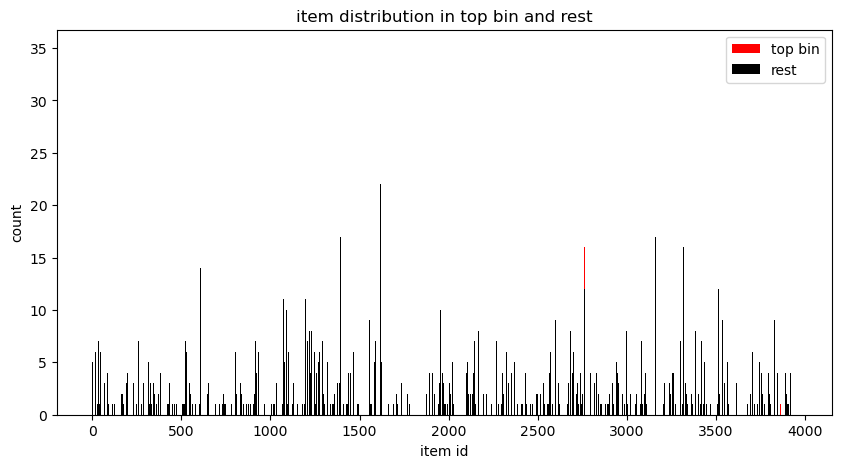

In [48]:
item_num = cfg_as_dict["model"]["item_num"]
entire_items = set(range(1,item_num+1))

copied_record = copy.deepcopy(user_via_record)

top_bin_target_counts = {item_id: 0 for item_id in entire_items}
total_count_for_top_bin = 0
for index in top_bin_indices:
    target_item = copied_record["target_item"][index]
    top_bin_target_counts[target_item] += 1
    total_count_for_top_bin += 1
    
rest_target_counts = {item_id: 0 for item_id in entire_items}
total_count_for_rest = 0
for index in rest_indices:
    target_item = copied_record["target_item"][index]
    rest_target_counts[target_item] += 1
    total_count_for_rest += 1

print(f"total count for top bin: {total_count_for_top_bin}")
print(f"total count for rest: {total_count_for_rest}")
    
## make heat map of the item_id distribution in top bin and rest
plt.figure(figsize=(10, 5))
plt.bar(top_bin_target_counts.keys(), top_bin_target_counts.values(), color = "red", label = "top bin")
plt.bar(rest_target_counts.keys(), rest_target_counts.values(), color = "black", label = "rest")
plt.xlabel("item id")
plt.ylabel("count")
plt.title("item distribution in top bin and rest")
plt.legend()
plt.show()





In [49]:
## view entire frequency for top 100 recommended items
top100_recommended_counts = {item_id: 0 for item_id in entire_items}

for index in range(len(user_via_record["user_id"])):
    top100_indices = user_via_record["top100_indices"][index]
    for item_id in top100_indices:
        top100_recommended_counts[item_id] += 1



In [50]:

#print(top100_recommended_counts.keys())

top_10_percent_of_most_recommended_items = dict(sorted(top100_recommended_counts.items(), key = lambda x: x[1], reverse = True)[:int(len(entire_items) * 0.1)])

print(f"top 10 percent of most recommended items: {top_10_percent_of_most_recommended_items}")

top 10 percent of most recommended items: {3354: 3719, 2791: 3351, 2804: 3201, 2571: 2851, 1408: 2691, 2762: 2680, 2716: 2653, 3751: 2652, 913: 2616, 3398: 2553, 1965: 2550, 1213: 2482, 457: 2470, 968: 2411, 3793: 2399, 367: 2368, 260: 2367, 1641: 2341, 1394: 2339, 2693: 2326, 1252: 2275, 3481: 2274, 1960: 2245, 3175: 2242, 2355: 2213, 3147: 2191, 1748: 2185, 1527: 2184, 3624: 2124, 2352: 2119, 306: 2095, 904: 2077, 1777: 2039, 2702: 2037, 589: 1993, 587: 1955, 1265: 1884, 3037: 1881, 3408: 1868, 1127: 1866, 356: 1830, 1222: 1804, 1513: 1804, 748: 1793, 594: 1783, 858: 1739, 1148: 1729, 1282: 1723, 3176: 1719, 50: 1698, 1291: 1690, 2599: 1687, 2997: 1682, 1704: 1675, 1028: 1671, 3948: 1670, 3802: 1665, 593: 1661, 3578: 1657, 3897: 1652, 3274: 1635, 2959: 1632, 104: 1627, 150: 1618, 1964: 1581, 880: 1564, 1544: 1559, 1945: 1533, 800: 1482, 3114: 1457, 2797: 1454, 1958: 1435, 293: 1432, 2080: 1412, 3072: 1394, 1032: 1391, 912: 1386, 39: 1383, 3534: 1382, 1500: 1377, 3683: 1373, 1729: 136